/var/folders/4s/_33kvc6507v69vbr_vy9xsjc0000gq/T/ipykernel_7614/1988251056.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=labels_circles, cmap="tab20c")


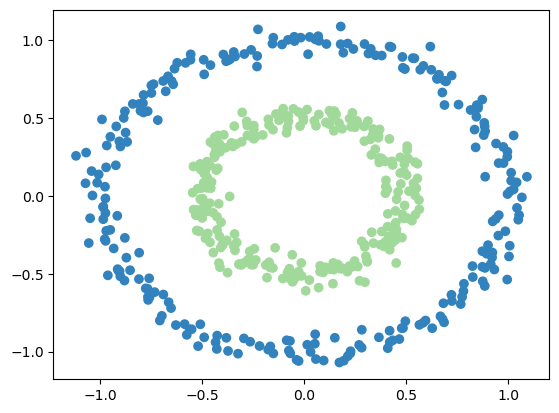

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN, KMeans
import clustergraph.clustergraph as cg
import clustergraph.distances as d
from clustergraph.Metric_distortion_class import Metric_distortion

data = pd.read_csv("data/noisy_circles.csv", sep=",", header=None)
X = data.to_numpy()

model_DB = DBSCAN(eps=0.2, min_samples=5)
predict_DB = model_DB.fit_predict(X)
X1 = X[predict_DB == 0]
X2 = X[predict_DB == 1]
colors = []
for i in range(len(predict_DB)):
    if predict_DB[i] == 0:
        colors.append("#3182bd")
    else:
        colors.append("#a1d99b")

labels_circles = np.array(colors)
plt.scatter(X[:, 0], X[:, 1], c=labels_circles, cmap="tab20c")
plt.show()

### Use of a clustering algorithm

In [2]:
model_KM = KMeans(20, random_state=42)
prediction_KM = model_KM.fit_predict(X)

In [3]:
from clustergraph.utils import get_clusters_from_scikit

clusters = get_clusters_from_scikit(prediction_KM)
clusters

[array([  3,   4,  25,  30,  37,  63,  97, 114, 115, 120, 136, 137, 138,
        170, 179, 187, 191, 194, 213, 235, 266, 272, 344, 346, 372, 387,
        411, 412, 413, 425, 431, 436, 451, 455, 462, 463]),
 array([ 44,  60,  69, 102, 142, 165, 189, 255, 260, 299, 308, 338, 347,
        352, 408, 416, 471, 483, 485]),
 array([  1,   2,  11,  61,  68,  76, 110, 117, 160, 205, 210, 219, 232,
        236, 242, 243, 258, 286, 297, 320, 323, 330, 336, 342, 349, 353,
        358, 383, 395, 405, 417, 420, 423, 430, 438, 452, 457, 470, 489,
        494]),
 array([ 12,  21,  27,  34,  50,  75,  92,  95, 116, 123, 128, 151, 158,
        173, 234, 245, 264, 265, 270, 281, 298, 317, 326, 334, 351, 367,
        375, 382, 393, 414, 419, 424, 441, 492]),
 array([ 20,  46,  83,  99, 118, 175, 267, 275, 280, 283, 284, 289, 360,
        374, 394, 407, 445, 490]),
 array([  6,  13,  15,  36,  64,  79,  80,  85, 108, 132, 134, 146, 167,
        176, 178, 188, 190, 193, 195, 209, 225, 262, 300, 301, 303, 32

### ClusterGraph's creation

In [5]:
%%time
# Creation of the object
cluster_g = cg.ClusterGraph(clusters = clusters, X = X, metric_clusters = "average" )


CPU times: user 348 ms, sys: 7.3 ms, total: 355 ms
Wall time: 353 ms


### Creation the k nearest neighbors graph

In [4]:
nb = 10
neigh = NearestNeighbors(n_neighbors=nb, radius=1)
neigh.fit(X=X)
nn_adjacency = neigh.kneighbors_graph(X=X, n_neighbors=nb, mode="distance")

nn_Graph = nx.from_scipy_sparse_array(nn_adjacency, edge_attribute="label")

## remove self edges
for node in nn_Graph.nodes:
    nn_Graph.remove_edge(node, node)

print("Number connected components : ", nx.number_connected_components(nn_Graph))

Number connected components :  2


### Metric distortion pruning

In [5]:
from clustergraph.GraphPruning import GraphPruning

gp = GraphPruning(cluster_g.graph, type_pruning="md", knn_g=nn_Graph, X=X, algo="bf")
pruned_gg, md = gp.prune(score=True)

In [ ]:
plt.scatter(range(len(md)), md)

### Connectivity pruning

In [ ]:
from clustergraph.GraphPruning import GraphPruning

gp = GraphPruning(cluster_g.graph)
pruned_g, conn = gp.prune(nb_edge_pruned=130, score=True)

In [ ]:
plt.scatter(range(len(conn)), conn)

### Prepare the graph to be plotted

In [ ]:
from clustergraph.c_GraphPreprocess import GraphPreprocess

# Initialisation of the graphproprocessing object
g_prepro = GraphPreprocess(pruned_gg)

# Coloring the nodes depending on the dominant labels inside each cluster
g_prepro.fit_nodes(type_coloring="label", color_labels=labels_circles)
# Normalizing the edges' lengths
g_prepro.fit_edges()

g = g_prepro.graph

### Plot the pruned ClusterGraph

In [ ]:
import clustergraph.plot_graph as pg

pg.plot_colored_graph(g, num_edges=len(g.edges), size_nodes=1000)

### Plot with a slider bar 

In [ ]:
pg.display_graph_with_slider(g)